In [1]:
from model import StochasticPolicy
import numpy as np
import pandas as pd
from make_data import BoxMaker
import torch

In [2]:
policy = StochasticPolicy(80*45,2)

In [3]:
datamaker = BoxMaker()

In [4]:
data=datamaker.get_data_dict()

In [5]:
data = np.array(data)

In [31]:
state = []
dim = []
action = []
for i in range(len(data)):
    state.append(data[i,0])
    dim.append(data[i,1])
    action.append(data[i,2][:2])
state=torch.from_numpy(np.array(state))/45
dim=torch.from_numpy(np.array(dim))/45
action=torch.from_numpy(np.array(action))


In [21]:
a,m,s=policy.sample(state.float(),dim.float())

In [22]:
a

tensor([[-0.7975,  0.8363],
        [ 0.7626,  0.6619],
        [-0.7027, -0.6847],
        [ 0.5062,  0.6905],
        [-0.4756,  0.1252],
        [ 0.5738, -0.3649],
        [-0.7550, -0.0152],
        [-0.9898, -0.9477],
        [ 0.5108, -0.4468],
        [ 0.9623,  0.5362],
        [-0.4386, -0.5187],
        [ 0.7979,  0.0224],
        [ 0.5941, -0.3949],
        [-0.9985, -0.5595],
        [ 0.9583, -0.5775],
        [-0.2425, -0.4407],
        [-0.9505,  0.0014],
        [-0.4073, -0.2848],
        [-0.9988, -0.2925],
        [ 0.4370,  0.1461],
        [-0.9996,  0.4023],
        [-0.9999,  0.0979],
        [-0.8732, -0.0867],
        [ 1.0000, -0.2277],
        [ 0.9999,  0.5163],
        [ 0.9963,  0.3143],
        [-0.8990, -0.2464]], grad_fn=<TanhBackward>)

In [13]:
def get_shifted_action(action):
#     action = action.detach().numpy()
    x = action[:,0]
    y = action[:,1]
    x = x*40 + 40
    y = y*45/2 + 45/2
#     return x.astype(int),y.astype(int)
    return x,y
    

In [80]:
x,y=get_shifted_action(a)

In [81]:
actio

torch.Size([27, 2])

In [82]:
pred=torch.cat([x.unsqueeze(1),y.unsqueeze(1)],dim=1)

In [45]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [84]:
F.mse_loss(pred,action.float())

tensor(1198.8383, grad_fn=<MseLossBackward>)

# Test Imitation Learning

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from model import StochasticPolicy
from make_data import BoxMaker
import torch

In [12]:
policy = StochasticPolicy(80*45,2)
checkpoint = torch.load('./Models/policy.pt')
policy.load_state_dict(checkpoint['model_state_dict'])
policy.eval()

StochasticPolicy(
  (linear1): Linear(in_features=3600, out_features=500, bias=True)
  (linear2): Linear(in_features=500, out_features=100, bias=True)
  (linear3_mean): Linear(in_features=100, out_features=50, bias=True)
  (linear4_mean): Linear(in_features=50, out_features=9, bias=True)
  (linear5_mean): Linear(in_features=12, out_features=2, bias=True)
  (linear3_std): Linear(in_features=100, out_features=50, bias=True)
  (linear4_std): Linear(in_features=50, out_features=9, bias=True)
  (linear5_std): Linear(in_features=12, out_features=2, bias=True)
)

In [13]:
data_maker=BoxMaker()

In [14]:
data = data_maker.get_data_dict()
data=np.array(data)

In [15]:
def get_shifted_action(action):
#     action = action.detach().numpy()
    x = action[:,0]
    y = action[:,1]
    y = y*40 + 40
    x = x*45/2 + 45/2
#     return x.astype(int),y.astype(int)
    return x,y
    

In [16]:
def getFeasibility(ldc,x,y,l,b,h):
    feasible = 0
    if len(np.unique(ldc[x:x+b,y:y+l])) == 1 and ldc[x,y]+h<=45:
        feasible=1
    return feasible

In [17]:
data = data_maker.get_data_dict()
data=np.array(data)

In [20]:
data = data_maker.get_data_dict()
data=np.array(data)
ldc=np.zeros((45,80))
act = 5
k=3
vol=0
search = np.arange(0,k,1)-int(k/2)
state = data[0,0]
while len(data)>0:
    num_act=0
    state = np.copy(ldc.flatten())
    dim = data[0,1]
    ideal_pos=data[0,2]
    state_feed = torch.from_numpy(np.array(state))/45
    dim_feed   = torch.from_numpy(np.array(dim))/45
    a,m,s=policy.sample(state_feed.unsqueeze(0).float(),dim_feed.unsqueeze(0).float())
    x,y=get_shifted_action(a)
    x = x.int().detach() 
    y = y.int().detach()
    l=dim[0]
    b=dim[1]
    h=dim[2]
    feasible = getFeasibility(ldc,x,y,l,b,h)
    print([x.numpy()[0],y.numpy()[0]],l,b,h,ideal_pos)
    if feasible:
        ldc[x:x+b,y:y+l] += h
        print('PLACE')
        vol += l*b*h
        data = np.delete(data,0,0)
        act = 1
    done=0
    if not feasible:
        act = 0
        # check neighbouring region
        for i in search:
            for j in search:
                x_test = np.maximum(0,x+i)
                y_test = np.maximum(0,y+j)
                x_test = np.minimum(x_test,45)
                y_test = np.minimum(y_test,80)
                feasible = getFeasibility(ldc,x_test,y_test,l,b,h)
#                 print(x_test,y_test)
                if feasible:
                    ldc[x_test:x_test+b,y_test:y_test+l] += h
                    vol+=l+b+h
                    print('PLACE')
                    data = np.delete(data,0,0)
                    act=1
                    done=1
                    break
            if done:
                break
        data = np.delete(data,0,0)
                
                
#     plt.imshow(ldc,cmap='hot',vmin=0,vmax=45)
#     plt.show()
print(vol/(45*45*80)*100)

[0, 0] 25 21 15 [0 0 0]
PLACE
[6, 7] 16 21 15 [ 0 25  0]
[6, 7] 13 21 15 [ 0 41  0]
[6, 7] 13 21 15 [ 0 54  0]
[6, 7] 13 21 15 [ 0 67  0]
[6, 7] 25 14 15 [21  0  0]
[6, 7] 16 14 15 [21 25  0]
PLACE
[2, 8] 13 14 15 [21 41  0]
[2, 8] 13 14 15 [21 54  0]
[2, 8] 13 14 15 [21 67  0]
[2, 8] 25 10 15 [35  0  0]
[2, 8] 16 10 15 [35 25  0]
[2, 8] 13 10 15 [35 41  0]
[2, 8] 13 10 15 [35 54  0]
[2, 8] 13 10 15 [35 67  0]
[2, 8] 25 21 17 [ 0  0 15]
[2, 8] 16 21 17 [ 0 25 15]
[2, 8] 13 21 17 [ 0 41 15]
[2, 8] 13 21 17 [ 0 54 15]
[2, 8] 13 21 17 [ 0 67 15]
[2, 8] 25 14 17 [21  0 15]
[2, 8] 16 14 17 [21 25 15]
[2, 8] 13 14 17 [21 41 15]
[2, 8] 13 14 17 [21 54 15]
[2, 8] 13 14 17 [21 67 15]
[2, 8] 25 10 17 [35  0 15]
[2, 8] 16 10 17 [35 25 15]
[2, 8] 13 10 17 [35 41 15]
[2, 8] 13 10 17 [35 54 15]
[2, 8] 13 10 17 [35 67 15]
[2, 8] 25 21 13 [ 0  0 32]
[2, 8] 16 21 13 [ 0 25 32]
[2, 8] 13 21 13 [ 0 41 32]
[2, 8] 13 21 13 [ 0 54 32]
[2, 8] 13 21 13 [ 0 67 32]
[2, 8] 25 14 13 [21  0 32]
[2, 8] 16 14 13 [21

In [65]:
data_copy = np.copy(data)
data_copy.shape

(36, 3)

In [64]:
np.delete(data_copy,0,0).shape

(35, 3)

In [66]:
len(data)

36

In [10]:
import torch
import torch.nn as nn
import numpy as np
from make_data import BoxMaker
from model import StochasticPolicyCNN

In [11]:
a=torch.rand((1,4,45,80))
b = torch.rand((1,12))

In [12]:
policy=StochasticPolicyCNN()

In [13]:
policy.sample(a,b)

(tensor([[ 0.3243, -0.1640]], grad_fn=<TanhBackward>),
 tensor([[-1.9542]], grad_fn=<SumBackward2>),
 tensor([[ 0.4402, -0.3998]], grad_fn=<TanhBackward>))

In [14]:
data_maker = BoxMaker(45,45,80)
data = data_maker.get_data_dict(False)

In [66]:
state = np.zeros((4,45,80))
dim   = np.zeros((12))

In [67]:
replayBuffer=[]
for i in range(5):
    state = np.roll(state,axis=0,shift=1)
    state[0,:,:] = data[i][0]
#     states.append(state)
    dim = np.roll(dim,shift=3)
    dim[:3] = data[i][1]
#     dims.append(dim)
    action = data[i][2]
    replayBuffer.append([state,dim,action])

In [71]:
np.array(replayBuffer)[0]

array([array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]

In [89]:
class ReplayBuffer(object):
	def __init__(self, max_size=1e4):
		self.storage = []
		self.max_size = max_size
		self.ptr = 0

	def add(self, data):
		if len(self.storage) == self.max_size:
			self.storage[int(self.ptr)] = data
			self.ptr = (self.ptr + 1) % self.max_size
		else:
			self.storage.append(data)

	def sample(self, batch_size=1):
		ind = np.random.randint(0, len(self.storage), size=batch_size)
		#[st_img,dim,action]
		x, y, u = [], [], []
		for i in ind:
			X, Y, U = self.storage[i]
			x.append(np.array(X, copy=False))
			y.append(np.array(Y, copy=False))
			u.append(np.array(U, copy=False))

		return np.array(x), np.array(y), np.array(u)
buff = ReplayBuffer(3)
for i in range(5):
    state = np.roll(state,axis=0,shift=1)
    state[0,:,:] = data[i][0]
#     states.append(state)
    dim = np.roll(dim,shift=3)
    dim[:3] = data[i][1]
#     dims.append(dim)
    action = data[i][2][:2]
    buff.add([state,dim,action])
#     replayBuffer.append([state,dim,action])

In [92]:
x,y,u = buff.sample(2)
print(x.shape,y.shape,u.shape)

(2, 4, 45, 80) (2, 12) (2, 2)


In [23]:
cur_state = data[0][0]

In [51]:
states[3][:,:,3]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [25]:
state[:,:,0] = cur_state

In [30]:
np.roll(state,axis=2,shift=1).shape

(45, 80, 4)

# Test Imitation Learning with history of states

In [1]:
from model import StochasticPolicyCNN
import numpy as np
import matplotlib.pyplot as plt
import torch
from make_data import BoxMaker

In [36]:
def get_shifted_action(action):
#     action = action.detach().numpy()
    x = action[:,0]
    y = action[:,1]
    y = y*40 + 40
    x = x*45/2 + 45/2
#     return x.astype(int),y.astype(int)
    return x,y

def getFeasibility(ldc,x,y,l,b,h):
    feasible = 0
    if len(np.unique(ldc[x:x+b,y:y+l])) == 1 and ldc[x,y]+h<=45:
        feasible=1
    return feasible

In [37]:
state = np.zeros((4,45,80))
dim   = np.zeros((12))
ldc = np.zeros((45,80))
data_maker = BoxMaker(45,45,80)
data = data_maker.get_data_dict(False)
def show(a):
    plt.imshow(a,cmap='hot',vmin=0,vmax=45)
    plt.show()
states=[]
dims=[]
actions=[]
for i in range(len(data)):
    ldc = np.copy(data[i][0])
    state = np.roll(state,axis=0,shift=1)
    state[0,:,:] = data[i][0]
    states.append(state)
    dim = np.roll(dim,shift=3)
    dim[:3] = data[i][1]
    dims.append(dim)
    action = data[i][2][:2]
    actions.append(action)

In [87]:
policy = StochasticPolicyCNN()
checkpoint = torch.load('./Models/policy.pt')
policy.load_state_dict(checkpoint['model_state_dict'])
policy.eval()
print()

In [91]:
import pandas as pd

In [100]:
opt_df = pd.DataFrame(opt)
opt_df = opt_df.rename(columns={0:'opt_x',1:'opt_y'})
pred_df= pd.DataFrame(pred)
pred_df = pred_df.rename(columns={0:'pred_x',1:'pred_y'})

In [101]:
df = pd.concat([pred_df,opt_df],axis=1)

In [104]:
state = np.zeros((4,45,80))
dim   = np.zeros((12))
ldc = np.zeros((45,80))
data_maker = BoxMaker(45,45,80)
data = data_maker.get_data_dict(False)
def show(a):
    plt.imshow(a,cmap='hot',vmin=0,vmax=45)
    plt.show()
states=[]
dims=[]
actions=[]
for i in range(len(data)):
    ldc = np.copy(data[i][0])
    state = np.roll(state,axis=0,shift=1)
    state[0,:,:] = data[i][0]
    states.append(state)
    dim = np.roll(dim,shift=3)
    dim[:3] = data[i][1]
    dims.append(dim)
    action = data[i][2][:2]
    actions.append(action)
opt=[]
pred=[]
for i in range(len(states)):
    feed_state = torch.FloatTensor(states[i]/45).unsqueeze(0)
    feed_dim   = torch.FloatTensor(dims[i]/45).unsqueeze(0)
    a,m,s = policy.sample(feed_state,feed_dim)
    x = get_shifted_action(a)[0].detach().numpy()[0]
    y = get_shifted_action(a)[1].detach().numpy()[0]
    pred.append([int(x),int(y)])
#     opt.append(actions[i])
    print(str([int(x),int(y)]),str(actions[i]))
    


[0, 0] [0 0]
[4, 12] [0 0]
[0, 0] [0 0]
[17, 16] [23  0]
[21, 0] [23  0]
[20, 0] [23  0]
[31, 0] [33  0]
[31, 0] [33  0]
[31, 0] [33  0]
[0, 38] [ 0 34]
[0, 36] [ 0 34]
[0, 32] [ 0 34]
[23, 33] [23 34]
[23, 34] [23 34]
[23, 33] [23 34]
[32, 33] [33 34]
[33, 32] [33 34]
[32, 32] [33 34]
[0, 49] [ 0 48]
[0, 47] [ 0 48]
[0, 47] [ 0 48]
[24, 46] [23 48]
[23, 48] [23 48]
[23, 47] [23 48]
[32, 46] [33 48]
[32, 47] [33 48]
[32, 47] [33 48]
[0, 62] [ 0 62]
[0, 62] [ 0 62]
[0, 62] [ 0 62]
[23, 62] [23 62]
[22, 61] [23 62]
[22, 60] [23 62]
[33, 61] [33 62]
[33, 61] [33 62]
[33, 61] [33 62]


# Test IL with history with actual change in state

In [105]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from model import StochasticPolicyCNN
import torch
from make_data import BoxMaker

In [106]:
def get_shifted_action(action):
#     action = action.detach().numpy()
    x = action[:,0]
    y = action[:,1]
    y = y*40 + 40
    x = x*45/2 + 45/2
#     return x.astype(int),y.astype(int)
    return x,y
def getFeasibility(ldc,x,y,l,b,h):
    feasible = 0
    if len(np.unique(ldc[x:x+b,y:y+l])) == 1 and ldc[x,y]+h<=45:
        feasible=1
    return feasible

In [173]:
cell_len = 80
cell_wid = 45
cell_ht  = 45
max_ldc_x  = 1
max_ldc_y =1
def getStabilityScore(i, j , ldc, dimn, currldc_x=0, currldc_y=0):
#     level = ldc[i,j]
    h = dimn[2]
    feasible = False
    found_flat = found_not_flat = 0
    if  (j >= cell_len*currldc_x) and (j+dimn[0] <= cell_len*(currldc_x+1)) and\
        (i >= cell_wid*currldc_y) and (i+dimn[1] <= cell_wid*(currldc_y+1)):
        level = ldc[i,j]
        if level + h <= cell_ht: 
            feasible = True
            # --------------------------------------------------- Flat position
            if len(np.unique(ldc[i:i+dimn[1], j:j+dimn[0]])) == 1:
                stab_score = 1
                found_flat = 1
            # ---------------------------------------------------- Non-Flat position
            if not found_flat:
                corners =  [ldc[i,j], ldc[i+dimn[1]-1,j], ldc[i,j+dimn[0]-1], ldc[i+dimn[1]-1, j+dimn[0]-1]]
                if (np.max(corners) == np.min(corners)) and (np.max(corners) == np.max(ldc[i:i+dimn[1],j:j+dimn[0]])):
                    stab_score = - np.sum(np.max(corners)-ldc[i:i+dimn[1],j:j+dimn[0]])/(dimn[0]*dimn[1]*cell_ht)
                    found_not_flat = 1


    if (found_flat) or (found_not_flat):
        minj = np.max((cell_len*currldc_x,j-1))
        maxj = np.min((cell_len*(currldc_x+1),j+dimn[0]))
        mini = np.max((cell_wid*(currldc_y),i-1))
        maxi = np.min((cell_wid*(currldc_y+1),i+dimn[1]))

        # Border for the upper edge
        if i==currldc_y*cell_wid: 
            upper_border = (cell_ht - 1 + np.ones_like(ldc[mini,j:(j+int(dimn[0]))])).tolist()
        else: 
            upper_border  = ldc[mini,j:(j+int(dimn[0]))].tolist()
        # Stability for the upper edge
        unique_ht = np.unique(upper_border)
        if len(unique_ht) == 1:
            stab_score += 0.5
            if unique_ht[0] == level: stab_score -= 2
            elif unique_ht[0] == cell_ht: stab_score += 1.5
            else:
                sscore = 1.-abs(unique_ht[0]-(level+h))/cell_ht
                if (unique_ht[0]>level): stab_score += 1.5*sscore
                else:                    stab_score += 0.75*sscore
        else:
            stab_score += 0.25*(1.-len(unique_ht)/h)
            stab_score += 0.25*(1.-sum(abs(ht-(level+h)) for ht in unique_ht)/(h*len(unique_ht)))
            stab_score += 0.50*sum(ht!=level for ht in unique_ht)/len(unique_ht)
        #border.extend(upper_border)
        del upper_border

        # Border for the left edge
        if j==currldc_x*cell_len:
            left_border = (cell_ht - 1 + np.ones_like(ldc[i:(i+int(dimn[1])),minj])).tolist()
        else: 
            left_border = ldc[i:(i+int(dimn[1])),minj].tolist()
        # Stability for the left edge
        unique_ht = np.unique(left_border)
        if len(unique_ht) == 1:
            stab_score += 0.5
            if unique_ht[0] == level: stab_score -= 2
            elif unique_ht[0] == cell_ht: stab_score += 1.5
            else:
                sscore = 1.-abs(unique_ht[0]-(level+h))/cell_ht
                if (unique_ht[0]>level): stab_score += 1.5*sscore
                else:                    stab_score += 0.75*sscore
        else:
            stab_score += 0.25*(1.-len(unique_ht)/h)
            stab_score += 0.25*(1.-sum(abs(ht-(level+h)) for ht in unique_ht)/(h*len(unique_ht)))
            stab_score += 0.50*sum(ht!=level for ht in unique_ht)/len(unique_ht)
        #border.extend(left_border)
        del left_border

        # Border for the lower edge
        if (i+dimn[1] < cell_wid*(currldc_y+1)): lower_border = ldc[maxi,j:(j+int(dimn[0]))].tolist()
        else: lower_border = (cell_ht - 1 + np.ones_like(ldc[maxi-1,j:(j+int(dimn[0]))])).tolist()
        # Stability for the lower edge
        unique_ht = np.unique(lower_border)
        if len(unique_ht) == 1:
            stab_score += 0.5
            if lower_border[0] == level: stab_score -= 2
            elif lower_border[0] == cell_ht: stab_score += 1.5
            else:
                sscore = 1.-abs(unique_ht[0]-(level+h))/cell_ht
                if (unique_ht[0]>level): stab_score += 1.5*sscore
                else:                    stab_score += 0.75*sscore
        else:
            stab_score += 0.25*(1.-len(unique_ht)/h)
            stab_score += 0.25*(1.-sum(abs(ht-(level+h)) for ht in unique_ht)/(h*len(unique_ht)))
            stab_score += 0.50*sum(ht!=level for ht in unique_ht)/len(unique_ht)
        #border.extend(lower_border)
        del lower_border

        # Border for the right edge
        if (j+dimn[0] < (currldc_x+1)*cell_len): right_border = ldc[i:(i+int(dimn[1])),maxj].tolist()
        else: 
            right_border = (cell_ht - 1 + np.ones_like(ldc[i:(i+int(dimn[1])),maxj-1])).tolist()
        # Stability for the right edge
        unique_ht = np.unique(right_border)
        if len(unique_ht) == 1:
            stab_score += 0.5
            if right_border[0] == level: 
                stab_score -= 2
            elif right_border[0] == cell_ht: 
                stab_score += 1.5
            else:
                sscore = 1.-abs(unique_ht[0]-(level+h))/cell_ht
                if (unique_ht[0]>level): 
                    stab_score += 1.5*sscore
                else:                    
                    stab_score += 0.75*sscore
        else:
            stab_score += 0.25*(1.-len(unique_ht)/h)
            stab_score += 0.25*(1.-sum(abs(ht-(level+h)) for ht in unique_ht)/(h*len(unique_ht)))
            stab_score += 0.50*sum(ht!=level for ht in unique_ht)/len(unique_ht)
        #border.extend(right_border)
        del right_border
        
        
        # Check the upper edge for continuity
        if i == currldc_y*cell_wid: stab_score += 0.02
        else:
            # In the upper-left corner
            if (j == currldc_x*cell_len) :
                stab_score += 0.01
            # In the upper-right corner
            if ((j+dimn[0]) == (currldc_x+1)*cell_len) :
                stab_score += 0.01
        # Check the lower edge for continuity
        if i+dimn[1] == cell_wid*(currldc_y+1): 
            stab_score += 0.02
        else:
            # In the lower-left corner
            if (j == currldc_x*cell_len) :
                stab_score += 0.01
            # In the lower-right corner
            if ((j+dimn[0]) == (currldc_x+1)*cell_len) :
                stab_score += 0.01
        # Check the left edge for continuity
        if j == currldc_x*cell_len: 
            stab_score += 0.02
        else:
            # In the upper-left corner
            if (i == currldc_y*cell_wid): 
                stab_score += 0.01
            # In the lower-left corner
            if (i+dimn[1] == cell_wid*(currldc_y+1)): 
                stab_score += 0.01
        # Check the right edge for continuity 
        if j+dimn[0] == (currldc_x+1)*cell_len: 
            stab_score += 0.02
        else:
            # In the upper-left corner
            if (i == currldc_y*cell_wid) : 
                stab_score += 0.01
            # In the lower-left corner
            if (i+dimn[1] == cell_wid*(currldc_y+1)): 
                stab_score += 0.01 
            
        stab_score -= currldc_x/max_ldc_x + currldc_y/max_ldc_y
        stab_score -= 0.05*(i/((currldc_y+1)*cell_wid) + j/((currldc_x+1)*cell_len))
        stab_score -= level / cell_ht
        #stab_score += (dimn[0]*dimn[1])/(cell_len*cell_wid)
    else:
        stab_score = -10
        
    return stab_score


In [174]:
state = np.zeros((4,45,80))
dim   = np.zeros((12))
ldc = np.zeros((45,80))
data_maker = BoxMaker(45,45,80)
data = data_maker.get_data_dict(False)
def show(a):
    plt.imshow(a,cmap='hot',vmin=0,vmax=45)
    plt.show()
states=[]
dims=[]
actions=[]
for i in range(len(data)):
    ldc = np.copy(data[i][0])
    state = np.roll(state,axis=0,shift=1)
    state[0,:,:] = data[i][0]
    states.append(state)
    dim = np.roll(dim,shift=3)
    dim[:3] = data[i][1]
    dims.append(dim)
    action = data[i][2][:2]
    actions.append(action)
    
opt=[]
pred=[]
state = np.zeros((4,45,80))
search_range=6 # will search in +-search_range
search = np.arange(0,search_range,1)
neg_search = -np.arange(1,search_range,1)
search_arr = np.append(search,neg_search)
# search = np.arange(1,search_range,1)
# search_arr = np.append(search,-search)
print(search_arr)
for i in range(len(dims)):
#     state = 
    cur_dim = np.array(dims[i][:3]).astype(np.uint16)
    feed_state = torch.FloatTensor(states[i]/45).unsqueeze(0)
    feed_dim   = torch.FloatTensor(dims[i]/45).unsqueeze(0)
    a,m,s = policy.sample(feed_state,feed_dim)
    x = int(get_shifted_action(a)[0].detach().numpy()[0])
    y = int(get_shifted_action(a)[1].detach().numpy()[0])
    pred.append([x,y])
    opt.append(actions[i])
    opt_x = actions[i][0]
    opt_y = actions[i][1]
    score = getStabilityScore(x,y , states[i][0,:,:], dimn = cur_dim, currldc_x=0, currldc_y=0)
    opt_score = getStabilityScore(opt_x,opt_y , states[i][0,:,:], dimn = cur_dim, currldc_x=0, currldc_y=0)
#     if score == -10:
    found=0
    for x_s in search_arr:
        for y_s in search_arr:
#                 print(x_s,y_s)
            search_score = getStabilityScore(x+x_s,y+y_s , states[i][0,:,:], dimn = cur_dim, currldc_x=0, currldc_y=0)
            if search_score == opt_score:
                score = search_score
                found = 1
                x = x+x_s
                y = y+y_s
                break
        if found:
            break
    print(int(score),int(opt_score),str([int(x),int(y)]),str(actions[i]))
#     print(str([int(x),int(y)]),str(actions[i]))
    

[ 0  1  2  3  4  5 -1 -2 -3 -4 -5]
2 2 [0, 0] [0 0]
-10 6 [2, 8] [0 0]
5 5 [0, 0] [0 0]
-10 2 [2, 23] [ 0 36]
6 6 [0, 36] [ 0 36]
5 5 [0, 36] [ 0 36]
5 5 [0, 63] [ 0 63]
7 7 [0, 63] [ 0 63]
6 6 [0, 63] [ 0 63]
2 2 [10, 0] [10  0]
6 6 [10, 0] [10  0]
5 5 [10, 0] [10  0]
1 1 [10, 36] [10 36]
6 6 [10, 36] [10 36]
5 5 [10, 36] [10 36]
5 5 [10, 63] [10 63]
7 7 [10, 63] [10 63]
6 6 [10, 63] [10 63]
2 2 [23, 0] [23  0]
6 6 [23, 0] [23  0]
5 5 [23, 0] [23  0]
1 1 [23, 36] [23 36]
6 6 [23, 36] [23 36]
5 5 [23, 36] [23 36]
5 5 [23, 63] [23 63]
7 7 [23, 63] [23 63]
6 6 [23, 63] [23 63]
5 5 [35, 0] [35  0]
7 7 [35, 0] [35  0]
6 6 [35, 0] [35  0]
5 5 [35, 36] [35 36]
7 7 [35, 36] [35 36]
6 6 [35, 36] [35 36]
8 8 [35, 63] [35 63]
8 8 [35, 63] [35 63]
8 8 [35, 63] [35 63]


In [189]:
state = np.zeros((4,45,80))
dim   = np.zeros((12))
ldc = np.zeros((45,80))
data_maker = BoxMaker(45,45,80)
data = data_maker.get_data_dict(False)
def show(a):
    plt.imshow(a,cmap='hot',vmin=0,vmax=45)
    plt.show()
states=[]
dims=[]
actions=[]
for i in range(len(data)):
    ldc = np.copy(data[i][0])
    state = np.roll(state,axis=0,shift=1)
    state[0,:,:] = data[i][0]
    states.append(state)
    dim = np.roll(dim,shift=3)
    dim[:3] = data[i][1]
    dims.append(dim)
    action = data[i][2][:2]
    actions.append(action)
    
opt=[]
pred=[]
state = np.zeros((4,45,80))
search_range=6 # will search in +-search_range
search = np.arange(0,search_range,1)
neg_search = -np.arange(1,search_range,1)
search_arr = np.append(search,neg_search)
# search = np.arange(1,search_range,1)
# search_arr = np.append(search,-search)
print(search_arr)
for i in range(len(dims)):
#     state = 
    cur_dim = np.array(dims[i][:3]).astype(np.uint16)
    feed_state = torch.FloatTensor(states[i]/45).unsqueeze(0)
    feed_dim   = torch.FloatTensor(dims[i]/45).unsqueeze(0)
    a,m,s = policy.sample(feed_state,feed_dim)
    x = int(get_shifted_action(a)[0].detach().numpy()[0])
    y = int(get_shifted_action(a)[1].detach().numpy()[0])
    pred.append([x,y])
    opt.append(actions[i])
    opt_x = actions[i][0]
    opt_y = actions[i][1]
    score = getStabilityScore(x,y , states[i][0,:,:], dimn = cur_dim, currldc_x=0, currldc_y=0)
    opt_score = getStabilityScore(opt_x,opt_y , states[i][0,:,:], dimn = cur_dim, currldc_x=0, currldc_y=0)
    if score <=0:
        x_nw = x
        y_nw = y
        for x_s in search_arr:
            for y_s in search_arr:
#                     print(x_s,y_s)
                search_score = getStabilityScore(x_nw+x_s,y_nw+y_s , states[i][0,:,:], dimn = cur_dim, currldc_x=0, currldc_y=0)
                if search_score > score:
                    score = search_score
                    x = x_nw+x_s
                    y = y_nw+y_s
    print(int(score),int(opt_score),str([int(x),int(y)]),str(actions[i]))
#     print(str([int(x),int(y)]),str(actions[i]))
    

[ 0  1  2  3  4  5 -1 -2 -3 -4 -5]
2 2 [0, 0] [0 0]
-10 2 [1, 17] [12  0]
5 5 [29, 0] [29  0]
2 2 [0, 45] [ 0 45]
1 1 [12, 45] [12 45]
5 5 [29, 45] [29 45]
5 5 [0, 68] [ 0 68]
5 5 [12, 68] [12 68]
8 8 [29, 68] [29 68]
1 1 [0, 0] [0 0]
1 1 [12, 0] [12  0]
5 5 [29, 0] [29  0]
1 1 [0, 45] [ 0 45]
1 1 [12, 45] [12 45]
5 5 [29, 45] [29 45]
5 5 [0, 68] [ 0 68]
5 5 [12, 68] [12 68]
8 8 [29, 68] [29 68]
1 1 [0, 0] [0 0]
1 1 [12, 0] [12  0]
4 4 [29, 0] [29  0]
1 1 [0, 45] [ 0 45]
1 1 [12, 45] [12 45]
4 4 [29, 45] [29 45]
4 4 [0, 68] [ 0 68]
4 4 [12, 68] [12 68]
8 8 [29, 68] [29 68]


100.0 88.74814814814815 11.251851851851852


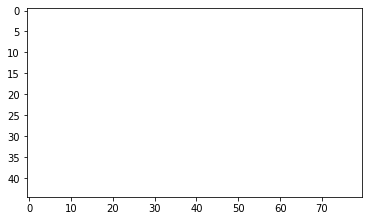

In [369]:
search_range=6 # will search in +-search_range
search = np.arange(0,search_range,1)
neg_search = -np.arange(1,search_range,1)
search_arr = np.append(search,neg_search)

def show(a):
    plt.imshow(a,cmap='hot',vmin=0,vmax=45)
    plt.show()
    
def step(state,action,dims):
    l,b,h = dims
    x,y = action
    ldc = np.copy(state[0,:,:])
    state = np.roll(state,axis=0,shift=1)
    state[0,:,:] = ldc
    state[0,x:x+b,y:y+l] += h
    return state

def get_pos(state,dim):
    feed_state = torch.FloatTensor(state/45).unsqueeze(0)
    feed_dim   = torch.FloatTensor(dim/45).unsqueeze(0)
    cur_dim = np.array(dims[i][:3]).astype(np.uint16)
    a,m,s = policy.sample(feed_state,feed_dim)
    x = int(get_shifted_action(a)[0].detach().numpy()[0])
    y = int(get_shifted_action(a)[1].detach().numpy()[0])
    score = getStabilityScore(x,y , state[0,:,:], dimn = cur_dim, currldc_x=0, currldc_y=0)
    if score <= 0:
        x_nw = x
        y_nw = y
        for x_s in search_arr:
            for y_s in search_arr:
                search_score = getStabilityScore(x_nw+x_s,y_nw+y_s , state[0,:,:], dimn = cur_dim, currldc_x=0, currldc_y=0)
                if search_score > score:
                    score = search_score
                    x = x_nw+x_s
                    y = y_nw+y_s
    return x,y,score

state = np.zeros((4,45,80))
dim   = np.zeros((12))
ldc = np.zeros((45,80))
data_maker = BoxMaker(45,45,80)
data = data_maker.get_data_dict(False)
states=[]
dims=[]
actions=[]
for i in range(len(data)):
    ldc = np.copy(data[i][0])
    state = np.roll(state,axis=0,shift=1)
    state[0,:,:] = data[i][0]
    states.append(state)
    dim = np.roll(dim,shift=3)
    dim[:3] = data[i][1]
    dims.append(dim)
    action = data[i][2][:2]
    actions.append(action)

# tot_vol = 0
# state = np.zeros((4,45,80))
# for i in range(len(dims)):
#     cur_dim = np.array(dims[i][:3]).astype(np.uint16)
#     x,y,score = get_pos(state,dims[i])
# #     print(x,y)
# #     print(score)
#     if score!= -10:
#         state = step(state,[x,y],cur_dim)
#         tot_vol += cur_dim[0]*cur_dim[1]*cur_dim[2]
# print(tot_vol/(80*45*45)*100)
# show(state[0,:,:])

tot_vol = 0
state = np.zeros((4,45,80))
orig_len = len(dims)
# print(orig_len)
i = 0
search_space=[]
# while len(dims)>0:
walle_vol = 0
packman_vol=0
for i in range(len(dims)):
    cur_dim = np.array(dims[i][:3]).astype(np.uint16)
    l,b,h = cur_dim
    x,y,score = get_pos(state,dims[i])
#     print(score)
    if score!= -10:
        state = step(state,[x,y],cur_dim)
        search_space.append([x,y])
        search_space.append([x+b,y])
        search_space.append([x,y+l])
        tot_vol += cur_dim[0]*cur_dim[1]*cur_dim[2]
        packman_vol+=cur_dim[0]*cur_dim[1]*cur_dim[2]
    if score == -10:
#         dims.append(dims[i])
        max_score = -10
        x_pos = 0
        y_pos = 0
        for x_w,y_w in search_space:
            walle_score = getStabilityScore(x_w,y_w , state[0,:,:], dimn = cur_dim, currldc_x=0, currldc_y=0)
            if walle_score > max_score:
                max_score = walle_score
                x_pos = x_w
                y_pos = y_w
        if walle_score != -10:
            x = x_pos; y = y_pos
            state = step(state,[x,y],cur_dim)
            search_space.append([x,y])
            search_space.append([x+b,y])
            search_space.append([x,y+l])
            tot_vol += cur_dim[0]*cur_dim[1]*cur_dim[2]
            walle_vol+=cur_dim[0]*cur_dim[1]*cur_dim[2]
                
#     if i == 1*orig_len:
#         break
#     i += 1
print(tot_vol/(80*45*45)*100,packman_vol/(80*45*45)*100,walle_vol/(80*45*45)*100)
show(state[0,:,:])
